In [12]:
import json
from collections import Counter
import math, operator
import numpy
import heapq
import random
from sklearn import svm
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords

ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()
# nltk.download('stopwords')
# nltk.download('wordnet')
stopwords = set(stopwords.words('english'))

train_file_path = "train.json"
validation_file_path = "validation.json"


def calc_precision(predicted_categories, real_categories, category):
    num_true_predicts = 0
    for i in range(len(predicted_categories)):
        if predicted_categories[i] == real_categories[i]:
            if predicted_categories[i] == category:
                num_true_predicts += 1
    return num_true_predicts / predicted_categories.count(category)


def calc_recall(predicted_categories, real_categories, category):
    num_true_predicts = 0
    for i in range(len(predicted_categories)):
        if predicted_categories[i] == real_categories[i]:
            if predicted_categories[i] == category:
                num_true_predicts += 1
    return num_true_predicts / real_categories.count(category)


def calc_accuracy(predicted_categories, real_categories):
    num_true_predicts = 0
    for i in range(len(predicted_categories)):
        if predicted_categories[i] == real_categories[i]:
            num_true_predicts += 1
    return num_true_predicts / len(predicted_categories)


def calc_confusion_matrix(predicted_categories, real_categories, num_of_categories):
    matrix = []
    for i in range(num_of_categories):
        matrix.append([0] * num_of_categories)
    for i in range(len(real_categories)):
        matrix[real_categories[i] - 1][predicted_categories[i] - 1] += 1
    return matrix


def calc_macro_averaged_f1(predicted_categories, real_categories, num_of_categories):
    f1_values = []
    for category in range(1, num_of_categories + 1):
        category_precision = calc_precision(predicted_categories, real_categories, category)
        category_recall = calc_recall(predicted_categories, real_categories, category)
        f1_values.append(2 * category_precision * category_recall / (category_precision + category_recall))
    return sum(f1_values) / num_of_categories


def prepare_text(raw_text, mode="none"):
    punctuation_marks = [".", "!", "?", ",", ":", ";", "(", ")", "[", "]", "{", "}", '"', "'"]
    prepared_text = ""
    for character in raw_text:
        if character not in punctuation_marks:
            prepared_text += character.lower()
    if mode == "none":
        return prepared_text.split()
    elif mode == "stemming":
        return [ps.stem(word) for word in prepared_text.split()]
    elif mode == "lemmatization":
        return [lemmatizer.lemmatize(word) for word in prepared_text.split()]
    elif mode == "stopword-removal":
        return [word for word in prepared_text.split() if not word in stopwords]
    elif mode == "stemming&stopword-removal":
        return [ps.stem(word) for word in prepared_text.split() if not word in stopwords]
    elif mode == "lemmatization&stopword-removal":
        return [lemmatizer.lemmatize(word) for word in prepared_text.split() if not word in stopwords]


def knn(k, nltk_mode="none", method='cosine-similarity'):
    f = open(train_file_path, "r")
    train_docs = json.loads(f.read())
    title_weight = 1
    doc_nums = 0
    doc_occurrences = {}
    for train_doc in train_docs:
        title_words = prepare_text(train_doc['title'], nltk_mode)
        body_words = prepare_text(train_doc['body'], nltk_mode)
        for word in set(list(title_words) + list(body_words)):
            if word not in doc_occurrences:
                doc_occurrences[word] = 1
            else:
                doc_occurrences[word] += 1
        doc_nums += 1
    vector_space = {}
    doc_id = 0
    for train_doc in train_docs:
        vector_space[doc_id] = {}
        vector_space[doc_id]['words'] = {}
        title_words = prepare_text(train_doc['title'], nltk_mode)
        body_words = prepare_text(train_doc['body'], nltk_mode)
        category = train_doc['category']
        vector_space[doc_id]['length2'] = 0
        title_counts = Counter(title_words)
        body_counts = Counter(body_words)
        for word in set(list(title_counts.keys()) + list(body_counts.keys())):
            word_title_count = title_counts[word] if word in title_counts else 0
            word_body_count = body_counts[word] if word in body_counts else 0
            tf_idf = (title_weight * word_title_count + word_body_count) * (
            math.log10(doc_nums / doc_occurrences[word]))
            vector_space[doc_id]['words'][word] = tf_idf
            vector_space[doc_id]['length2'] += (tf_idf * tf_idf)
            vector_space[doc_id]['category'] = category
        doc_id += 1
    f = open(validation_file_path, "r")
    validation_docs = json.loads(f.read())
    real_categories = []
    predicted_categories = []
    for validation_doc in validation_docs:
        validation_doc_vector = {'words': {}, 'length2': 0}
        real_categories.append(validation_doc['category'])
        title_words = prepare_text(validation_doc['title'], nltk_mode)
        body_words = prepare_text(validation_doc['body'], nltk_mode)
        title_counts = Counter(title_words)
        body_counts = Counter(body_words)
        for word in set(list(title_counts.keys()) + list(body_counts.keys())):
            word_title_count = title_counts[word] if word in title_counts else 0
            word_body_count = body_counts[word] if word in body_counts else 0
            if word in doc_occurrences:
                tf_idf = (title_weight * word_title_count + word_body_count) * (
                math.log10(doc_nums / doc_occurrences[word]))
                validation_doc_vector['words'][word] = tf_idf
                validation_doc_vector['length2'] += (tf_idf * tf_idf)
        scores = {}
        if method == 'euclidean-similarity':
            for train_doc in vector_space:
                dot_product = 0
                for word in validation_doc_vector['words']:
                    if word in vector_space[train_doc]['words']:
                        dot_product += validation_doc_vector['words'][word] * vector_space[train_doc]['words'][word]
                scores[train_doc] = vector_space[train_doc]['length2'] + validation_doc_vector['length2'] - 2 * dot_product
            top_docs = heapq.nsmallest(k, scores, key=scores.get)
        elif method == 'cosine-similarity':
            for train_doc in vector_space:
                dot_product = 0
                for word in vector_space[train_doc]['words']:
                    if word in validation_doc_vector['words']:
                        dot_product += validation_doc_vector['words'][word] * vector_space[train_doc]['words'][word]
                scores[train_doc] = dot_product / (
                    math.sqrt(vector_space[train_doc]['length2']) * validation_doc_vector['length2'])
            top_docs = heapq.nlargest(k, scores, key=scores.get)
        classes = [vector_space[doc]['category'] for doc in top_docs]
        predicted_categories.append(max(set(classes), key=classes.count))
    precisions = [calc_precision(predicted_categories, real_categories, category) for category in range(1, 5)]
    recalls = [calc_recall(predicted_categories, real_categories, category) for category in range(1, 5)]
    accuracy = calc_accuracy(predicted_categories, real_categories)
    confusion_matrix = calc_confusion_matrix(predicted_categories, real_categories, 4)
    macro_averaged_f1 = calc_macro_averaged_f1(predicted_categories, real_categories, 4)
    return precisions, recalls, accuracy, confusion_matrix, macro_averaged_f1


def naive_bayes(smoothing_factor, nltk_mode="none"):
    f = open(train_file_path, "r")
    train_docs = json.loads(f.read())
    title_weight = 1
    categories = {1: [], 2: [], 3: [], 4: []}
    word_counts_in_categories = {}
    doc_id = 0
    prior = {}
    vocab = []
    for doc in train_docs:
        title_words = prepare_text(doc['title'], nltk_mode)
        body_words = prepare_text(doc['body'], nltk_mode)
        category = doc['category']
        categories[category].append(doc_id)
        title_counts = Counter(title_words)
        body_counts = Counter(body_words)
        for word in set(list(title_counts.keys()) + list(body_counts.keys())):
            if word not in vocab:
                vocab.append(word)
            word_title_count = title_counts[word] if word in title_counts else 0
            word_body_count = body_counts[word] if word in body_counts else 0
            if not category in word_counts_in_categories:
                word_counts_in_categories[category] = {word: (title_weight * word_title_count + word_body_count)}
            else:
                if word not in word_counts_in_categories[category]:
                    word_counts_in_categories[category][word] = (title_weight * word_title_count + word_body_count)
                else:
                    word_counts_in_categories[category][word] += (title_weight * word_title_count + word_body_count)
        doc_id += 1
    f = open(validation_file_path, "r")
    validation_docs = json.loads(f.read())
    num_of_docs = doc_id
    condprob = {}
    for category in categories:
        num_of_category_docs = len(categories[category])
        prior[category] = num_of_category_docs / num_of_docs
        for word in word_counts_in_categories[category]:
            term_occurrence_in_category = \
                word_counts_in_categories[category][word] if word in word_counts_in_categories[category] else 0
            sum_all_words_occurrences_in_category = sum(word_counts_in_categories[category].values())
            if word not in condprob:
                condprob[word] = {category:
                                      (term_occurrence_in_category + smoothing_factor) /
                                      (sum_all_words_occurrences_in_category + smoothing_factor * len(vocab))
                                  }
            else:
                condprob[word][category] = (term_occurrence_in_category + smoothing_factor) / \
                                           (sum_all_words_occurrences_in_category + smoothing_factor * len(vocab))
    real_categories = []
    predicted_categories = []
    print(prior)
    for doc in validation_docs:
        title_words = prepare_text(doc['title'], nltk_mode)
        body_words = prepare_text(doc['body'], nltk_mode)
        real_categories.append(doc['category'])
        score = {}
        for category in categories:
            score[category] = math.log(prior[category])
            for word in title_words + body_words:
                if word in condprob:
                    score[category] += math.log(condprob[word][category]) if category in condprob[word] else \
                        math.log(
                            smoothing_factor / (
                                sum(word_counts_in_categories[category].values()) + smoothing_factor * len(vocab)
                            )
                        )
        predicted_categories.append(max(score.items(), key=operator.itemgetter(1))[0])
    precisions = [calc_precision(predicted_categories, real_categories, category) for category in range(1, 5)]
    recalls = [calc_recall(predicted_categories, real_categories, category) for category in range(1, 5)]
    accuracy = calc_accuracy(predicted_categories, real_categories)
    confusion_matrix = calc_confusion_matrix(predicted_categories, real_categories, 4)
    macro_averaged_f1 = calc_macro_averaged_f1(predicted_categories, real_categories, 4)
    return precisions, recalls, accuracy, confusion_matrix, macro_averaged_f1


def svm_classifier(c):
    vocab = []
    f = open(train_file_path, "r")
    train_docs = json.loads(f.read())
    title_weight = 1
    doc_nums = 0
    doc_occurrences = {}
    for train_doc in train_docs:
        title_words = prepare_text(train_doc['title'])
        body_words = prepare_text(train_doc['body'])
        for word in set(list(title_words) + list(body_words)):
            if word not in vocab:
                vocab.append(word)
            if word not in doc_occurrences:
                doc_occurrences[word] = 1
            else:
                doc_occurrences[word] += 1
        doc_nums += 1
    vector_space = {}
    doc_id = 0
    for train_doc in train_docs:
        vector_space[doc_id] = {}
        vector_space[doc_id]['words'] = {}
        title_words = prepare_text(train_doc['title'])
        body_words = prepare_text(train_doc['body'])
        category = train_doc['category']
        title_counts = Counter(title_words)
        body_counts = Counter(body_words)
        for word in set(list(title_counts.keys()) + list(body_counts.keys())):
            word_title_count = title_counts[word] if word in title_counts else 0
            word_body_count = body_counts[word] if word in body_counts else 0
            vector_space[doc_id]['words'][word] = (title_weight * word_title_count + word_body_count) * \
                                                  (math.log10(doc_nums / doc_occurrences[word]))
            vector_space[doc_id]['category'] = category
        doc_id += 1
    vectors = [vector_space[doc]['words'] for doc in vector_space]
    categories = [vector_space[doc]['category'] for doc in vector_space]
    vectorizer = DictVectorizer(sparse=True)
    vectors = vectorizer.fit_transform(vectors)
    classifier = svm.LinearSVC(C=c)
    classifier.fit(vectors, categories)
    f = open(validation_file_path, "r")
    validation_docs = json.loads(f.read())
    real_categories = []
    predicted_categories = []
    for validation_doc in validation_docs:
        validation_doc_vector = {}
        real_categories.append(validation_doc['category'])
        title_words = prepare_text(validation_doc['title'])
        body_words = prepare_text(validation_doc['body'])
        title_counts = Counter(title_words)
        body_counts = Counter(body_words)
        for word in set(list(title_counts.keys()) + list(body_counts.keys())):
            word_title_count = title_counts[word] if word in title_counts else 0
            word_body_count = body_counts[word] if word in body_counts else 0
            validation_doc_vector[word] = (title_weight * word_title_count + word_body_count) * \
                                    (math.log10(doc_nums / doc_occurrences[word]) if word in doc_occurrences else 0)
        predicted_categories.append(classifier.predict(vectorizer.transform(validation_doc_vector))[0])
    precisions = [calc_precision(predicted_categories, real_categories, category) for category in range(1, 5)]
    recalls = [calc_recall(predicted_categories, real_categories, category) for category in range(1, 5)]
    accuracy = calc_accuracy(predicted_categories, real_categories)
    confusion_matrix = calc_confusion_matrix(predicted_categories, real_categories, 4)
    macro_averaged_f1 = calc_macro_averaged_f1(predicted_categories, real_categories, 4)
    return precisions, recalls, accuracy, confusion_matrix, macro_averaged_f1


def random_forest(num_of_trees, depth):
    vocab = []
    f = open(train_file_path, "r")
    train_docs = json.loads(f.read())
    title_weight = 1
    doc_nums = 0
    doc_occurrences = {}
    for train_doc in train_docs:
        title_words = prepare_text(train_doc['title'])
        body_words = prepare_text(train_doc['body'])
        for word in set(list(title_words) + list(body_words)):
            if word not in vocab:
                vocab.append(word)
            if word not in doc_occurrences:
                doc_occurrences[word] = 1
            else:
                doc_occurrences[word] += 1
        doc_nums += 1
    vector_space = {}
    doc_id = 0
    for train_doc in train_docs:
        vector_space[doc_id] = {}
        vector_space[doc_id]['words'] = {}
        title_words = prepare_text(train_doc['title'])
        body_words = prepare_text(train_doc['body'])
        category = train_doc['category']
        title_counts = Counter(title_words)
        body_counts = Counter(body_words)
        for word in set(list(title_counts.keys()) + list(body_counts.keys())):
            word_title_count = title_counts[word] if word in title_counts else 0
            word_body_count = body_counts[word] if word in body_counts else 0
            vector_space[doc_id]['words'][word] = (title_weight * word_title_count + word_body_count) * \
                                                  (math.log10(doc_nums / doc_occurrences[word]))
            vector_space[doc_id]['category'] = category
        doc_id += 1
    vectors = [vector_space[doc]['words'] for doc in vector_space]
    categories = [vector_space[doc]['category'] for doc in vector_space]
    vectorizer = DictVectorizer(sparse=True)
    vectors = vectorizer.fit_transform(vectors)
    classifier = RandomForestClassifier(max_depth=depth, random_state=0, n_estimators=num_of_trees)
    classifier.fit(vectors, categories)
    f = open(validation_file_path, "r")
    validation_docs = json.loads(f.read())
    real_categories = []
    predicted_categories = []
    for validation_doc in validation_docs:
        validation_doc_vector = {}
        real_categories.append(validation_doc['category'])
        title_words = prepare_text(validation_doc['title'])
        body_words = prepare_text(validation_doc['body'])
        title_counts = Counter(title_words)
        body_counts = Counter(body_words)
        for word in set(list(title_counts.keys()) + list(body_counts.keys())):
            word_title_count = title_counts[word] if word in title_counts else 0
            word_body_count = body_counts[word] if word in body_counts else 0
            validation_doc_vector[word] = (title_weight * word_title_count + word_body_count) * \
                                          (math.log10(doc_nums / doc_occurrences[word]) if word in doc_occurrences else 0)
        predicted_categories.append(classifier.predict(vectorizer.transform(validation_doc_vector))[0])
    precisions = [calc_precision(predicted_categories, real_categories, category) for category in range(1, 5)]
    recalls = [calc_recall(predicted_categories, real_categories, category) for category in range(1, 5)]
    accuracy = calc_accuracy(predicted_categories, real_categories)
    confusion_matrix = calc_confusion_matrix(predicted_categories, real_categories, 4)
    macro_averaged_f1 = calc_macro_averaged_f1(predicted_categories, real_categories, 4)
    return precisions, recalls, accuracy, confusion_matrix, macro_averaged_f1


def k_means():
    f = open(train_file_path, "r")
    train_docs = json.loads(f.read())
    title_weight = 1
    doc_nums = 0
    doc_occurrences = {}
    for train_doc in train_docs:
        title_words = prepare_text(train_doc['title'])
        body_words = prepare_text(train_doc['body'])
        for word in set(list(title_words) + list(body_words)):
            if word not in doc_occurrences:
                doc_occurrences[word] = 1
            else:
                doc_occurrences[word] += 1
        doc_nums += 1
    vector_space = {}
    doc_id = 0
    for train_doc in train_docs:
        vector_space[doc_id] = {}
        vector_space[doc_id]['words'] = {}
        title_words = prepare_text(train_doc['title'])
        body_words = prepare_text(train_doc['body'])
        category = train_doc['category']
        vector_space[doc_id]['length2'] = 0
        title_counts = Counter(title_words)
        body_counts = Counter(body_words)
        for word in set(list(title_counts.keys()) + list(body_counts.keys())):
            word_title_count = title_counts[word] if word in title_counts else 0
            word_body_count = body_counts[word] if word in body_counts else 0
            tf_idf = (title_weight * word_title_count + word_body_count) * (
                math.log10(doc_nums / doc_occurrences[word]))
            vector_space[doc_id]['words'][word] = tf_idf
            vector_space[doc_id]['length2'] += (tf_idf * tf_idf)
            vector_space[doc_id]['category'] = category
        doc_id += 1
    centroids = {}
    random_indexes = random.sample([doc_id for doc_id in vector_space], 4)
    for i in range(1, 5):
        centroids[i] = {'words': [], 'length2': 0}
        centroids[i]['words'] = vector_space[random_indexes[i - 1]]['words']
        centroids[i]['length2'] = vector_space[random_indexes[i - 1]]['length2']
    last_cost = float("inf")
    doc_clusters = {1: [], 2: [], 3: [], 4: []}
    for i in range(100):
        cost = 0
        doc_clusters = {1: [], 2: [], 3: [], 4: []}
        for doc in vector_space:
            distances = {}
            for centroid in centroids:
                dot_product = 0
                for word in vector_space[doc]['words']:
                    if word in centroids[centroid]['words']:
                        dot_product += centroids[centroid]['words'][word] * vector_space[doc]['words'][word]
                distances[centroid] = \
                    dot_product / (math.sqrt(vector_space[doc]['length2']) * math.sqrt(centroids[centroid]['length2']))
            predicted_cluster = heapq.nlargest(1, distances, key=distances.get)[0]
            doc_clusters[predicted_cluster].append(doc)
        for cluster in doc_clusters:
            new_centroid = {'words': {}, 'length2': 0}
            for doc in doc_clusters[cluster]:
                dot_product = 0
                for word in vector_space[doc]['words']:
                    if word in centroids[cluster]['words']:
                        dot_product += centroids[cluster]['words'][word] * vector_space[doc]['words'][word]
                cost += centroids[cluster]['length2'] + vector_space[doc]['length2'] - 2 * dot_product
                for word in vector_space[doc]['words']:
                    if not word in new_centroid['words']:
                        new_centroid['words'][word] = vector_space[doc]['words'][word]
                    else:
                        new_centroid['words'][word] += vector_space[doc]['words'][word]
                    new_centroid['length2'] += (vector_space[doc]['words'][word] * vector_space[doc]['words'][word])
            for word in new_centroid['words']:
                new_centroid['words'][word] = new_centroid['words'][word] / len(doc_clusters[cluster])
            new_centroid['length2'] = new_centroid['length2'] / len(doc_clusters[cluster])
            centroids[cluster] = new_centroid
        if math.fabs(cost - last_cost) < (10 ** (-7)):
            print('converged')
            break
        last_cost = cost
    number_of_samples = 2000
    sample_indexes = random.sample(range(0, len(vector_space)), number_of_samples)
    sample_docs = [vector_space[index]['words'] for index in sample_indexes]
    sample_real_categories = [vector_space[index]['category'] for index in sample_indexes]
    sample_predicted_categories = []
    for index in sample_indexes:
        for cluster in doc_clusters:
            if index in doc_clusters[cluster]:
                sample_predicted_categories.append(cluster)
                break
    vectorizer = DictVectorizer(sparse=False)
    sample_doc_vectors = vectorizer.fit_transform(sample_docs)
    tsne_data = TSNE().fit_transform(sample_doc_vectors)
    x = [a[0] for a in tsne_data]
    y = [a[1] for a in tsne_data]
    colors = ['r', 'g', 'b', 'y']
    colors2 = ['purple', 'black', 'pink', 'brown']
    fig1 = plt.figure()
    ax = fig1.add_subplot(111)
    for i in range(number_of_samples):
        ax.scatter(x[i], y[i], color=colors[sample_predicted_categories[i] - 1])
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111)
    for i in range(number_of_samples):
        ax2.scatter(x[i], y[i], color=colors2[sample_real_categories[i] - 1])
    plt.show()


def find_best_knn(method):
    k_values = [1, 3, 5]
    best_k = k_values[0]
    max_accuracy = float("-inf")
    for k in k_values:
        _, _, accuracy, _, _ = knn(k, "none", method)
        print(k, accuracy)
        if accuracy > max_accuracy:
            best_k = k
            max_accuracy = accuracy
    return best_k


def find_best_naive_bayes():
    smoothing_factors = [0.5, 1, 1.5, 2, 2.5, 3]
    best_smoothing_factor = smoothing_factors[0]
    max_accuracy = float("-inf")
    for smoothing_factor in smoothing_factors:
        _, _, accuracy, _, _ = naive_bayes(smoothing_factor)
        print(smoothing_factor, accuracy)
        if accuracy > max_accuracy:
            best_smoothing_factor = smoothing_factor
            max_accuracy = accuracy
    return best_smoothing_factor


def find_best_naive_bayes_with_nltk():
    nltk_modes = ["none", "stemming", "lemmatization", "stopword-removal"]
    best_nltk_mode = nltk_modes[0]
    max_accuracy = float("-inf")
    for nltk_mode in nltk_modes:
        _, _, accuracy, _, _ = naive_bayes(1.5, nltk_mode)
        print(nltk_mode, accuracy)
        if accuracy > max_accuracy:
            best_nltk_mode = nltk_mode
            max_accuracy = accuracy
    return best_nltk_mode

def find_best_svm():
    c_values = [0.03125, 0.0625, 0.125, 0.25, 1, 2]
    best_c = c_values[0]
    max_accuracy = float("-inf")
    for c in c_values:
        _, _, accuracy, _, _ = svm_classifier(c)
        print(c, accuracy)
        if accuracy > max_accuracy:
            best_c = c
            max_accuracy = accuracy
    return best_c


def find_best_random_forest():
    depths = [10]
    n_trees_values = [200]
    best_depth = depths[0]
    best_n_trees = n_trees_values[0]
    max_accuracy = float("-inf")
    for depth in depths:
        for n_trees in n_trees_values:
            _, _, accuracy, _, _ = random_forest(n_trees, depth)
            print(depth, n_trees, accuracy)
            if accuracy > max_accuracy:
                best_depth = depth
                best_n_trees = n_trees
                max_accuracy = accuracy
    return best_depth, best_n_trees



In [13]:
_, _, accuracy, _, _ = naive_bayes(1.5, 'stemming&stopword-removal')
print(accuracy)
_, _, accuracy, _, _ = naive_bayes(1.5, 'lemmatization&stopword-removal')
print(accuracy)
_, _, accuracy, _, _ = knn(5, 'stopword-removal' ,'cosine-similarity')
print(accuracy)

{1: 0.25, 2: 0.25, 3: 0.25, 4: 0.25}
0.8956666666666667
{1: 0.25, 2: 0.25, 3: 0.25, 4: 0.25}
0.8993333333333333


KeyboardInterrupt: 

converged


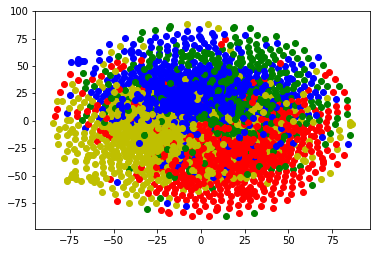

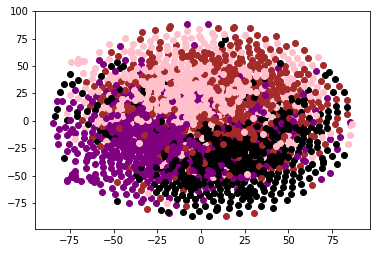

In [11]:
k_means()

In [7]:
print("NAIVE BAYES")
best_a = find_best_naive_bayes()
print(best_a)
print("NAIVE BAYES with nltk")
best_method = find_best_naive_bayes_with_nltk()
print(best_method)

NAIVE BAYES
0.5 0.8963333333333333
1 0.8973333333333333
1.5 0.8976666666666666
2 0.896
2.5 0.895
3 0.894
1.5
NAIVE BAYES with nltk
none 0.8976666666666666
stemming 0.8956666666666667
lemmatization 0.8973333333333333
stopword-removal 0.8983333333333333
stopword-removal


In [ ]:
print("knn cosine-similarity")
best_k = find_best_knn("euclidean-similarity")
print(best_k)
print("knn Euclidean-similarity")
best_k = find_best_knn("euclidean-similarity")
print(best_k)

In [8]:
print("SVM")
best_c = find_best_svm()
print(best_c)
print("Random Forest")
best_depth, best_n_trees = find_best_random_forest()
print(best_depth, best_n_trees)

SVM
0.03125 0.8876666666666667
0.0625 0.8833333333333333
0.125 0.881


c:\users\mehran\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.25 0.8776666666666667
1 0.8783333333333333
2 0.8776666666666667
0.03125
Random Forest
10 200 0.8103333333333333
10 200


In [9]:
precisions, recalls, accuracy, confusion_matrix, macro_averaged_f1 = naive_bayes(1.5)
print("Precision per category in order", precisions)
print("Recalls per category in order", recalls)
print("Accuracy", accuracy)
print("Confusion Matrix")
print("[")
for row in confusion_matrix:
    print(row, ",")
print("]")
print("Macro Averaged F1", macro_averaged_f1)

Precision per category in order [0.9139344262295082, 0.9363057324840764, 0.8755129958960328, 0.863031914893617]
Recalls per category in order [0.892, 0.98, 0.8533333333333334, 0.8653333333333333]
Accuracy 0.8976666666666666
Confusion Matrix
[
[669, 30, 28, 23] ,
[8, 735, 2, 5] ,
[25, 10, 640, 75] ,
[30, 10, 61, 649] ,
]
Macro Averaged F1 0.8972376785978419
